#  Unit 1



In [1]:
# we'll need these packages to begin
# !pip install stable-baselines3 plotnine polars sb3_contrib tensorboard


In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0" # change to -1 if you want to use CPU

import torch
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080', major=7, minor=5, total_memory=7786MB, multi_processor_count=46, uuid=b0ca1ad3-9d26-9967-4a5e-3fdaa82f4f79, L2_cache_size=4MB)

## Sustainable Salmon Harvest


$$X_{t+1} = X_t + r_x X \left( 1 -  \frac{X}{K} \right) + \sigma_x X \xi_x$$




In [1]:
import numpy as np
# pop = elk, caribou, wolves
# Caribou Scenario
def dynamics(pop, effort, harvest_fn, p, timestep=1):

    pop = harvest_fn(pop, effort)        
    X= pop[0]
    
    ## env fluctuations
    K = p["K"] # - 0.2 * np.sin(2 * np.pi * timestep / 3200)

    X += (p["r_x"] * X * (1 - X / K)
            + p["sigma_x"] * X * np.random.normal()
            )
    
    
    pop = np.array([X], dtype=np.float32)
    pop = np.clip(pop, [0], [np.Inf])
    return(pop)


In [2]:

initial_pop = [0.5]


parameters = {
"r_x": np.float32(0.13),
"K": np.float32(1),
"sigma_x": np.float32(0.05),
}


We must also define the dynamics of the action, a 'harvest' or culling function.  In this scenario, we imagine that we can cull either the elk or wolf population (or both).  We assume our control action introduces a percent mortality equal to the control effort applied times a catachability coefficient:

In [3]:
def harvest(pop, effort):
    q0 = 0.1 # catchability / restoration coefficients
    pop[0] = pop[0] * (1 - effort[0] * q0) # pop 0, salmon
    return pop


Lastly, we need to define the utility or reward derived from taking these actions under this population state.  In this scenario, our population control actions are costly, while we acrue a benefit proportional to the size of the current caribou population:

In [4]:
def utility(pop, effort):
    q0 = 0.1 # catchability / restoration coefficients

    benefits = effort[0] * pop[0] * q0
    # small cost to any harvesting
    costs = .00001 * sum(effort) # cost to culling

    # extinction penalty
    if np.any(pop <= 0.001):
        benefits -= 10
    return benefits - costs




To simulate our environment and allow RL algorithms to train on this environment, we define a simple python class using the gym module.  This class defines the possible action space as two continuously-valued action variables (culling effort of elk and wolves respectively), and three continuously valued state variables (population of elk, caribou and wolves).  To improve performance of RL training, it is necessary to transform the continuous space to -1, 1

In [5]:
import gymnasium as gym

class salmon(gym.Env):
    def __init__(self, config=None):
        config = config or {}
                                
        ## these parameters may be specified in config                                  
        self.Tmax = config.get("Tmax", 800)
        self.threshold = config.get("threshold", np.float32(1e-4))
        self.init_sigma = config.get("init_sigma", np.float32(1e-3))
        self.training = config.get("training", True)
        self.initial_pop = config.get("initial_pop", initial_pop)
        self.parameters = config.get("parameters", parameters)
        self.dynamics = config.get("dynamics", dynamics)
        self.harvest = config.get("harvest", harvest)
        self.utility = config.get("utility", utility)
        self.observe = config.get("observe", lambda state: state) # default to perfectly observed case
        self.bound = 2 * self.parameters["K"]
        
        self.action_space = gym.spaces.Box(
            np.array([-1], dtype=np.float32),
            np.array([1], dtype=np.float32),
            dtype = np.float32
        )
        self.observation_space = gym.spaces.Box(
            np.array([-1], dtype=np.float32),
            np.array([1], dtype=np.float32),
            dtype=np.float32,
        )        
        self.reset(seed=config.get("seed", None))


    def reset(self, *, seed=None, options=None):
        self.timestep = 0
        self.initial_pop += np.multiply(self.initial_pop, np.float32(self.init_sigma * np.random.normal(size=1)))
        self.state = self.state_units(self.initial_pop)
        info = {}
        return self.observe(self.state), info


    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        pop = self.population_units(self.state) # current state in natural units
        effort = (action + 1.) / 2

        # harvest and recruitment
        reward = self.utility(pop, effort)
        nextpop = self.dynamics(pop, effort, self.harvest, self.parameters, self.timestep)
        
        self.timestep += 1
        terminated = bool(self.timestep > self.Tmax)
        
        # in training mode only: punish for population collapse
        if any(pop <= self.threshold) and self.training:
            terminated = True
            reward -= 50/self.timestep
        
        self.state = self.state_units(nextpop) # transform into [-1, 1] space
        observation = self.observe(self.state) # same as self.state
        return observation, reward, terminated, False, {}
    
    def state_units(self, pop):
        self.state = 2 * pop / self.bound - 1
        self.state = np.clip(self.state,  
                             np.repeat(-1, self.state.__len__()), 
                             np.repeat(1, self.state.__len__()))
        return np.float32(self.state)
    
    def population_units(self, state):
        pop = (state + 1) * self.bound /2
        return np.clip(pop, 
                       np.repeat(0, pop.__len__()),
                       np.repeat(np.Inf, pop.__len__()))

    def timestep(self, effort):
        action = effort * 2 - 1
        observation, reward, terminated, done, info = self.step(action)
        obs = self.population_units(observation)
        return obs, reward, terminated
        
    
# verify that the environment is defined correctly    
from stable_baselines3.common.env_checker import check_env
env = salmon()
check_env(env, warn=True)    


# Simulating set actions

In [8]:

# A simple agent
class fixed_action:
    def __init__(self, effort):
        self.effort = np.array(effort, dtype=np.float32)

    def predict(self, observation, **kwargs):
        action = self.effort * 2 - 1
        return action, {}

# This Agent always gives the same action:
do_nothing = fixed_action([0])
do_nothing.predict([1])

(array([-1.], dtype=float32), {})

In [9]:

def simulate(agent, env, timeseries = True):
    df = []
    episode_reward = 0
    observation, _ = env.reset()
    for t in range(env.Tmax):
      obs = env.population_units(observation) # natural units
      action, _ = agent.predict(obs, deterministic=True)
      if timeseries:
          df.append([t, episode_reward, *action, *obs])
      observation, reward, terminated, done, info = env.step(action)
      episode_reward += reward
      if terminated or done:
        break
    
    return df, episode_reward




In [10]:
do_nothing = fixed_action([0])

df, episode_reward = simulate(do_nothing, env)

episode_reward

-122.91582701635328

/tmp/ipykernel_457/2368035051.py:6: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
/tmp/ipykernel_457/2368035051.py:8: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


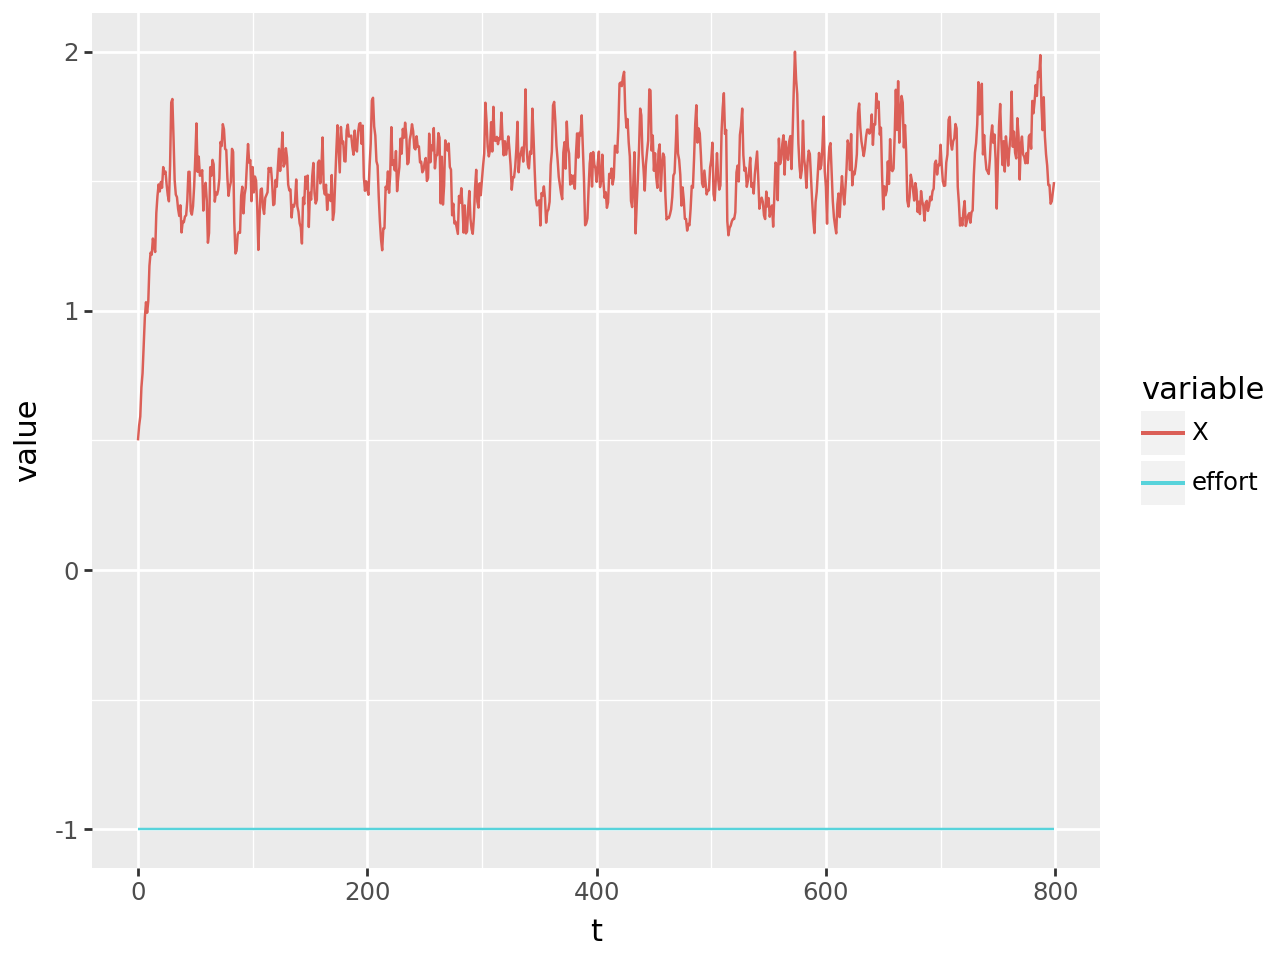

In [11]:

import polars as pl
from plotnine import ggplot, aes, geom_line
cols = ["t", "reward",  "effort", "X"]

def plot_sim(df):
    dfl = (pl.DataFrame(df, schema=cols).
            select(["t", "effort", "X"]).
            melt("t")
          )
    return ggplot(dfl, aes("t", "value", color="variable")) + geom_line()

plot_sim(df)

# Fixed strategy optimization

In [12]:
from skopt import gp_minimize, gbrt_minimize
from skopt.plots import plot_objective, plot_convergence, plot_gaussian_process

def g(x):
    agent = fixed_action(x)
    def my_function(i):
        np.random.seed(i)
        df, mu = simulate(agent, env, timeseries=False)
        return mu
        
    results = [my_function(i) for i in range(100)]
    return -np.mean(results)



In [13]:
%%time
# look for actions between [-1,1] for each species.
res = gp_minimize(g, [(-1.0, 1.0)], n_calls = 75, verbose=True, n_jobs=-1)
res.fun, res.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.8943
Function value obtained: 121.9463
Current minimum: 121.9463
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.4122
Function value obtained: 121.9479
Current minimum: 121.9463
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.4733
Function value obtained: 121.9494
Current minimum: 121.9463
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 5.6808
Function value obtained: 121.9510
Current minimum: 121.9463
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.4924
Function value obtained: 121.9526
Current minimum: 121.9463
Iteration No: 6

(-25.562727139109835, [0.8126083623894023])

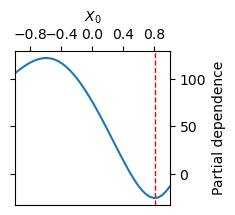

In [14]:
import matplotlib.pyplot as plt

ax = plot_objective(res)

plt.show()

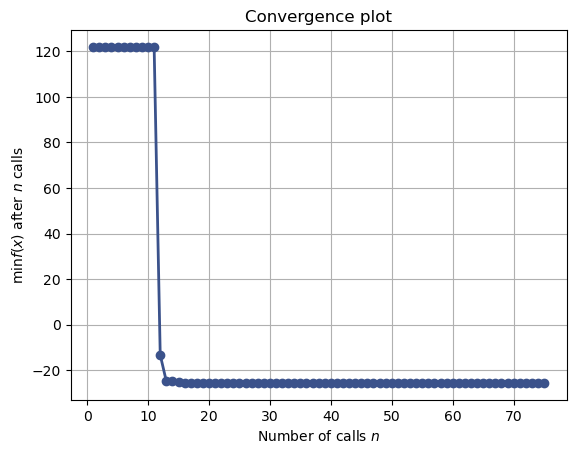

In [15]:

ax2 = plot_convergence(res)

plt.show()

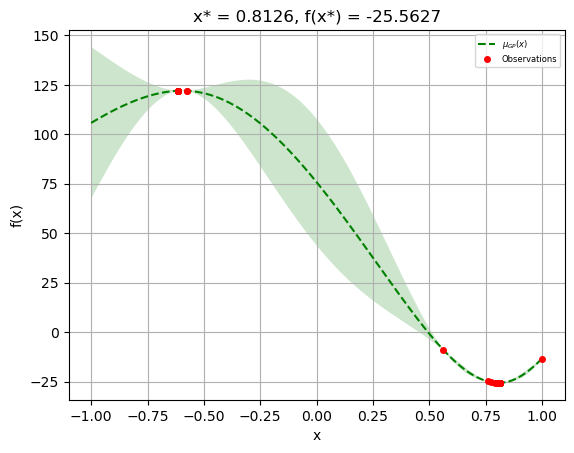

In [16]:

ax2 = plot_gaussian_process(res)

plt.show()

## RL Agents

In [17]:
from sb3_contrib import TQC, ARS
from stable_baselines3 import PPO, A2C, DQN, SAC, TD3
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env(salmon, 12)


In [18]:
model = ARS("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/jovyan/logs")
model.learn(total_timesteps=2_000_000)
model.save("ars_salmon_C")


25.159984926643755


/tmp/ipykernel_457/2368035051.py:6: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
/tmp/ipykernel_457/2368035051.py:8: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


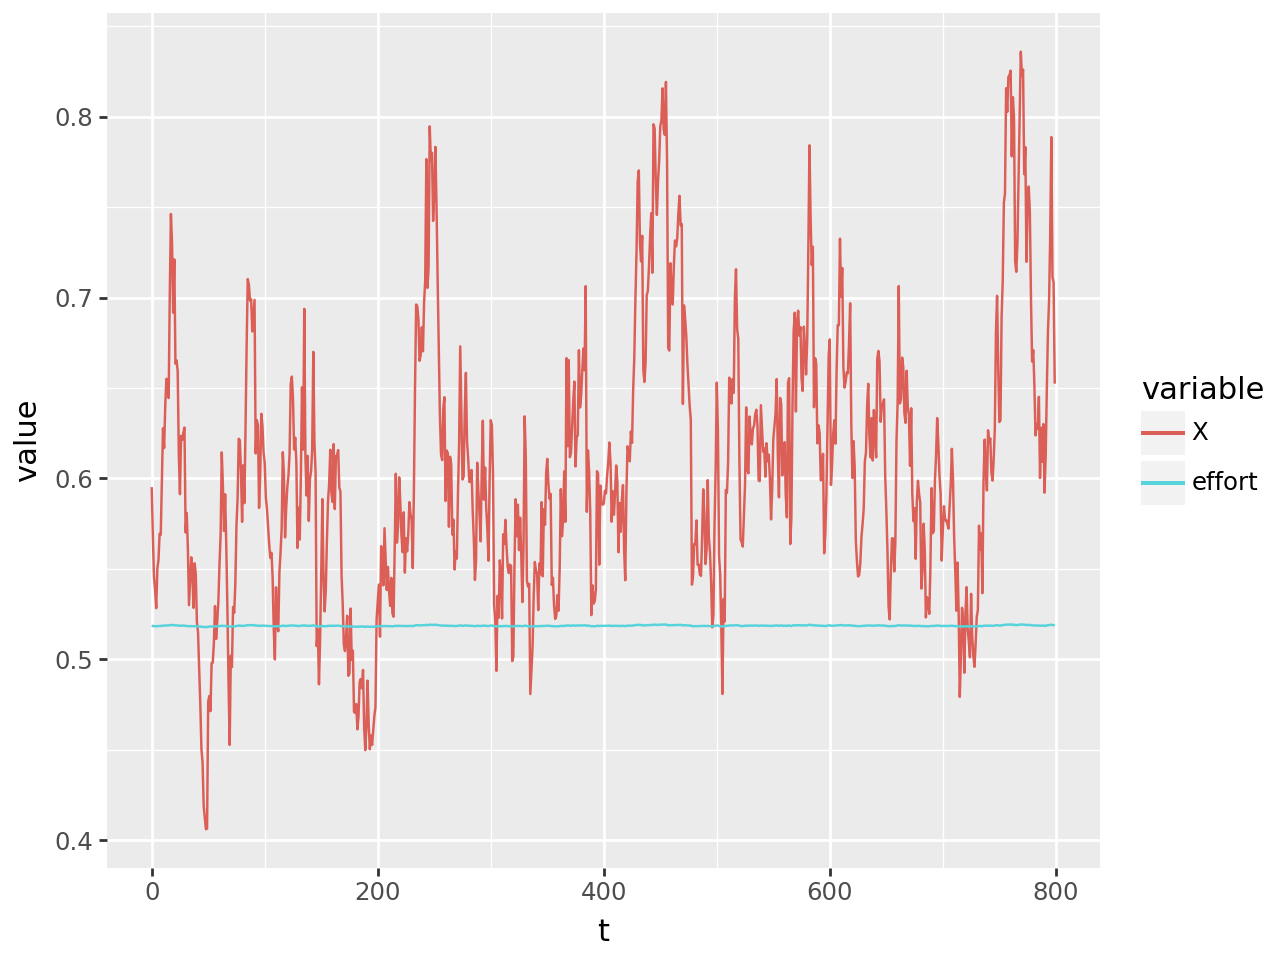

In [19]:
df, reward = simulate(model, env)
print(reward)
plot_sim(df)

In [20]:
%%time
model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/jovyan/logs", use_sde=True, device ="cuda")
model.learn(total_timesteps=200_000, tb_log_name="ppo-salmon")
model.save("ppo_salmon_C")

/opt/conda/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.


CPU times: user 2min 4s, sys: 972 ms, total: 2min 5s
Wall time: 2min 5s


In [21]:
%%time
model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/jovyan/logs", use_sde=True, device ="cpu")
model.learn(total_timesteps=200_000, tb_log_name="ppo-salmon-cpu")
model.save("ppo_salmon_cpu")

CPU times: user 17min 29s, sys: 518 ms, total: 17min 29s
Wall time: 1min 27s


-0.15330231616910953


/tmp/ipykernel_457/2368035051.py:6: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
/tmp/ipykernel_457/2368035051.py:8: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


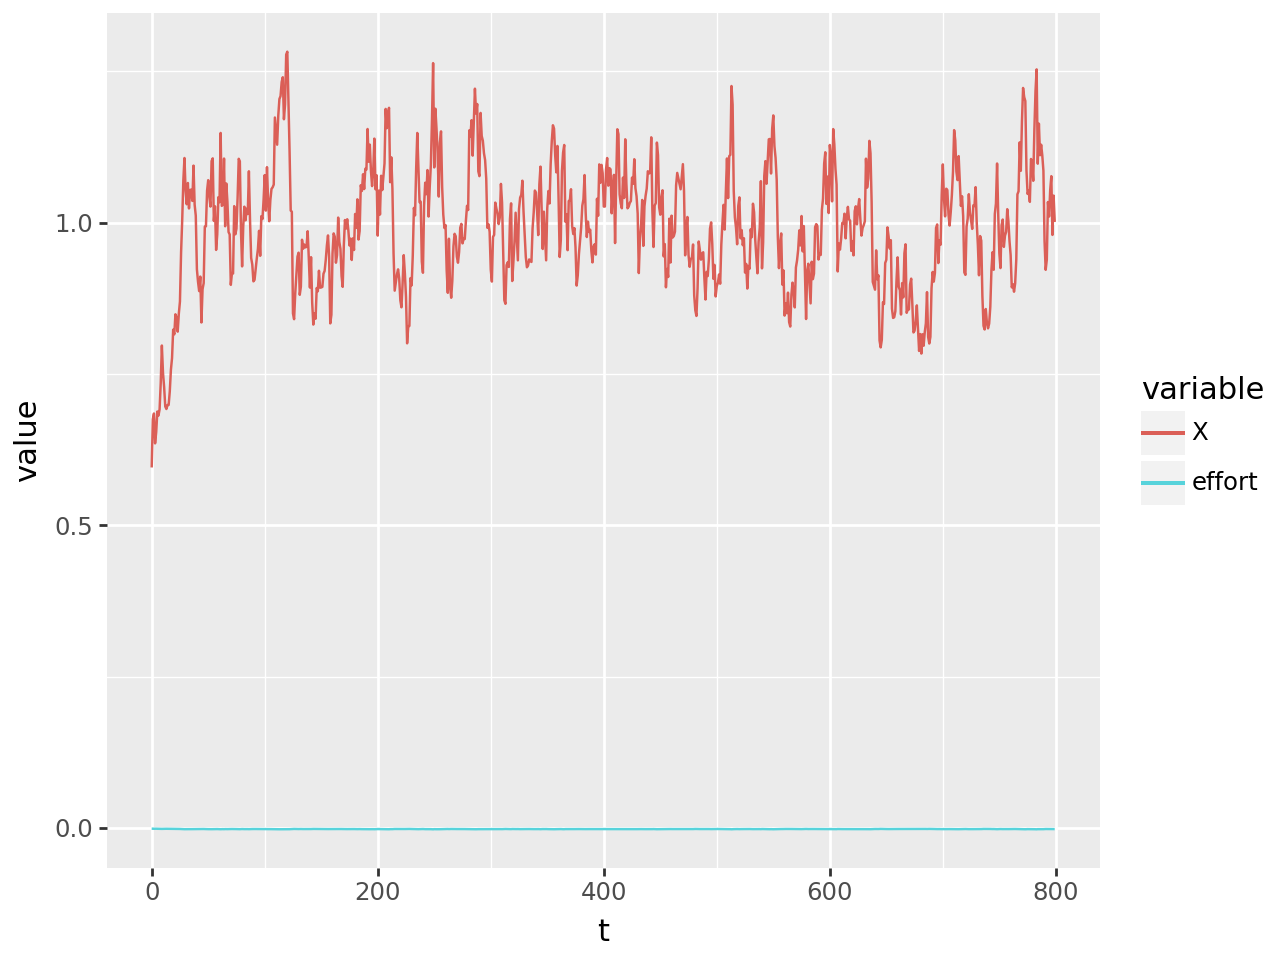

In [22]:
%%time
model = PPO("MlpPolicy", env)
agent = model.load("ppo_salmon_gpu")

df, reward = simulate(model, env)
print(reward)
plot_sim(df)

In [23]:
model = TQC("MlpPolicy", env, verbose=0, tensorboard_log="/home/jovyan/logs", use_sde=True)
model.learn(total_timesteps=100_000, tb_log_name= "tqc-salmon")
model.save("tqc_salmon_C")

14.394212881359861


/tmp/ipykernel_457/2368035051.py:6: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
/tmp/ipykernel_457/2368035051.py:8: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


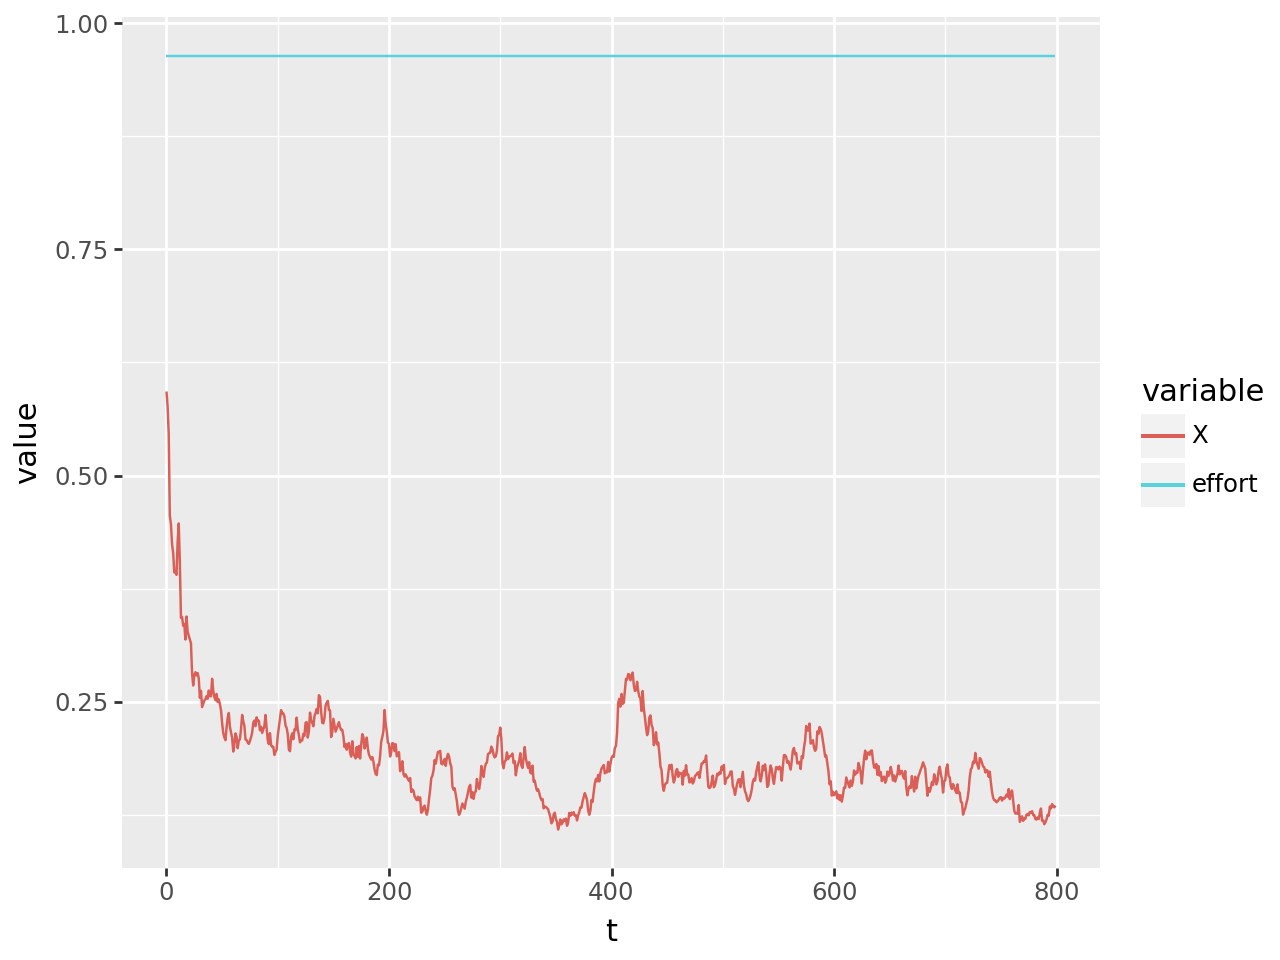

In [24]:
df, reward = simulate(model, env)
print(reward)
plot_sim(df)